
Accuracy by Scenario:

Accuracy for FT_With_Context:
  Scenario: Inventory Management, Accuracy: 56.25%
  Scenario: Employee Performance, Accuracy: 62.50%
  Scenario: cross_scenario, Accuracy: 43.75%
  Scenario: Customer Analysis, Accuracy: 46.67%
  Scenario: Supplier Analysis, Accuracy: 62.50%
  Scenario: Order Analysis, Accuracy: 66.67%
  Scenario: Product Analysis, Accuracy: 68.75%
  Scenario: Shipping Analysis, Accuracy: 68.75%
  Overall Accuracy: 59.52%

Accuracy for Base_With_Context:
  Scenario: Inventory Management, Accuracy: 50.00%
  Scenario: Employee Performance, Accuracy: 75.00%
  Scenario: cross_scenario, Accuracy: 43.75%
  Scenario: Customer Analysis, Accuracy: 60.00%
  Scenario: Supplier Analysis, Accuracy: 68.75%
  Scenario: Order Analysis, Accuracy: 53.33%
  Scenario: Product Analysis, Accuracy: 50.00%
  Scenario: Shipping Analysis, Accuracy: 56.25%
  Overall Accuracy: 57.14%

Accuracy by Difficulty Level:

Accuracy for FT_With_Context:
  Difficulty: easy, Accuracy: 7

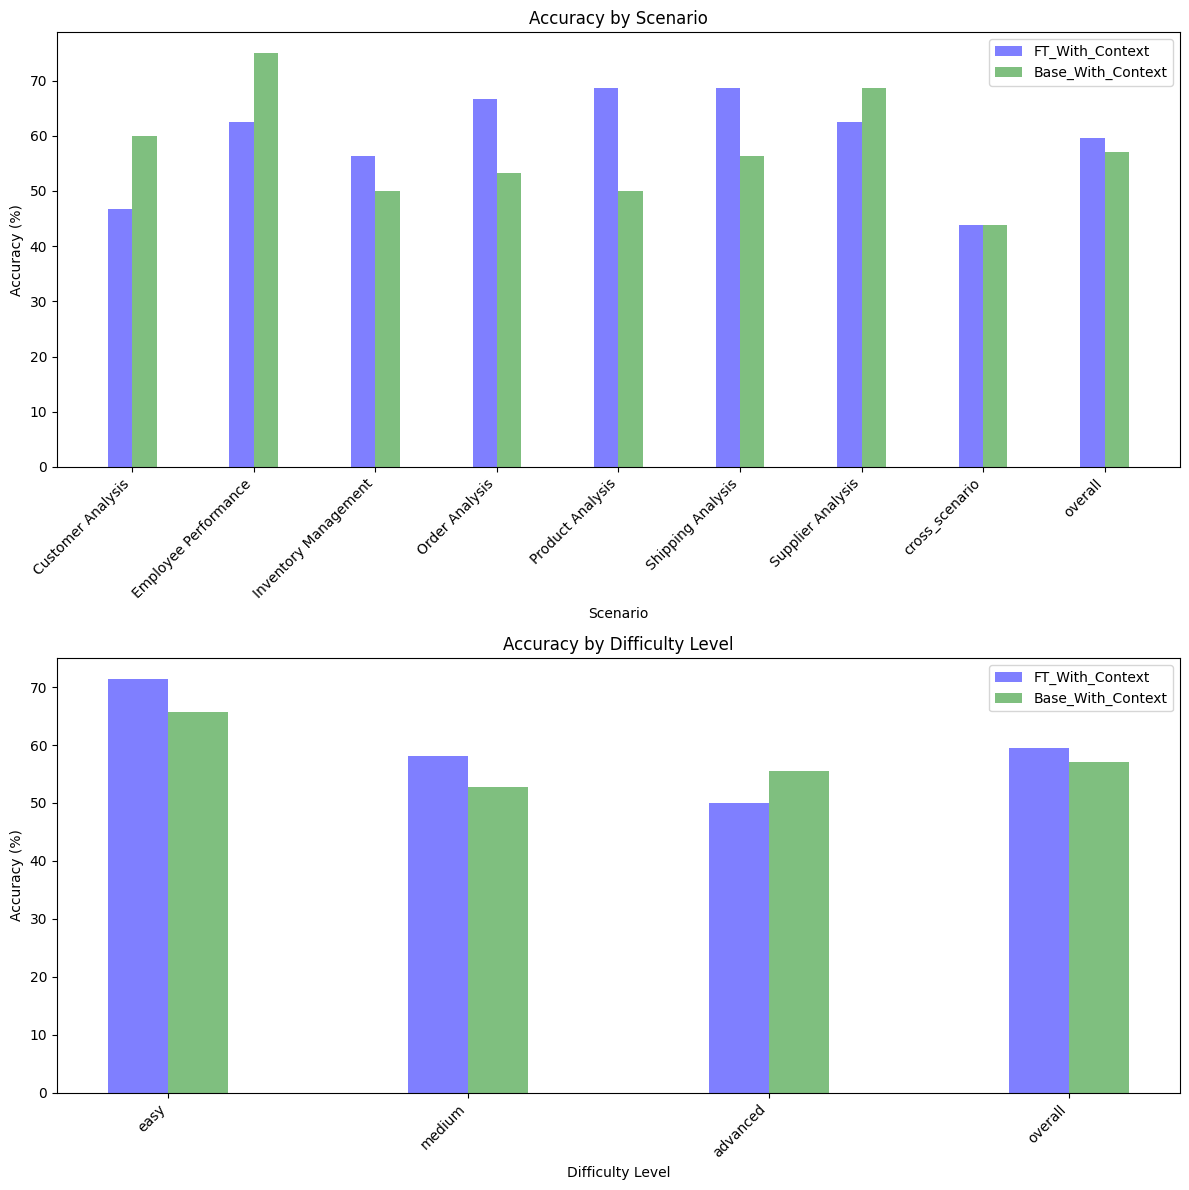

In [3]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  
import csv  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  

# Load environment variables  
env_path = Path('../../') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v5.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model with context
  
def generate_sql_query(question):  
    # formatted_question = f"## Database Schema and Business Metrics Definitions\n{schema}\n\n## Question: {question}"  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_SQL"),  
        messages=[  
            {"role": "system", "content": "You are a smart AI assistant with excellent SQL and data analysis skills. You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question, schema):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database.\n ## Database Schema and Business Metrics Definitions\n{schema} \nWhat is the ANSI SQL query for the following question? Just output the SQL query without comment or explanation in this format ```sql YOUR SQL query here```"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_sql_query_with_explanation(question, generated_query, ground_truth_query):  
    user_message = f"""  
    Evaluate if the generated SQL query accurately answers the user's question and yields the same results as the ground truth query. The queries do not need to be identical.

    ## User Question: {question}
    ## Generated SQL Query: {generated_query}
    ## Ground Truth SQL Query: {ground_truth_query}

    ## Output Format:
    - Provide a one-word response: 'yes' or 'no'.
    - Include a brief explanation in JSON format: {{"result": "yes/no", "explanation": "explanation"}}.

    Your Output:
    """  
  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a smart AI assistant, you have excellent data analysis and SQL skills. You apply SQL ANSI standard"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model with context  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    generated_query_with_context_ft = generate_sql_query(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question, schema)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_with_context_ft, explanation_ft = evaluate_sql_query_with_explanation(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base, explanation_base = evaluate_sql_query_with_explanation(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT"][scenario]["total"] += 1  
    results_by_setup["FT"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT"][scenario]["correct"] += 1  
        results_by_setup["FT"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        question,  
        ground_truth_query,  
        generated_query_with_context_base,  
        explanation_base,  
        generated_query_with_context_ft,  
        explanation_ft,  
        "Base" if evaluation_result_with_context_base == 'yes' and evaluation_result_with_context_ft == 'no' else "FT" if evaluation_result_with_context_ft == 'yes' and evaluation_result_with_context_base == 'no' else "both" if evaluation_result_with_context_ft == 'yes' and evaluation_result_with_context_base == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_sql_FT_no_context.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "User Question",  
        "Ground Truth SQL Query",  
        "Generated SQL by Base Model",  
        "Explanation by Base Model",  
        "Generated SQL by FT Model",  
        "Explanation by FT Model",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 0.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 0.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  



Accuracy by Scenario:

Accuracy for FT_With_Context:
  Scenario: Inventory Management, Accuracy: 50.00%
  Scenario: Employee Performance, Accuracy: 81.25%
  Scenario: cross_scenario, Accuracy: 37.50%
  Scenario: Customer Analysis, Accuracy: 53.33%
  Scenario: Supplier Analysis, Accuracy: 68.75%
  Scenario: Order Analysis, Accuracy: 66.67%
  Scenario: Product Analysis, Accuracy: 56.25%
  Scenario: Shipping Analysis, Accuracy: 68.75%
  Overall Accuracy: 60.32%

Accuracy for Base_With_Context:
  Scenario: Inventory Management, Accuracy: 56.25%
  Scenario: Employee Performance, Accuracy: 75.00%
  Scenario: cross_scenario, Accuracy: 43.75%
  Scenario: Customer Analysis, Accuracy: 66.67%
  Scenario: Supplier Analysis, Accuracy: 68.75%
  Scenario: Order Analysis, Accuracy: 46.67%
  Scenario: Product Analysis, Accuracy: 43.75%
  Scenario: Shipping Analysis, Accuracy: 62.50%
  Overall Accuracy: 57.94%

Accuracy by Difficulty Level:

Accuracy for FT_With_Context:
  Difficulty: easy, Accuracy: 6

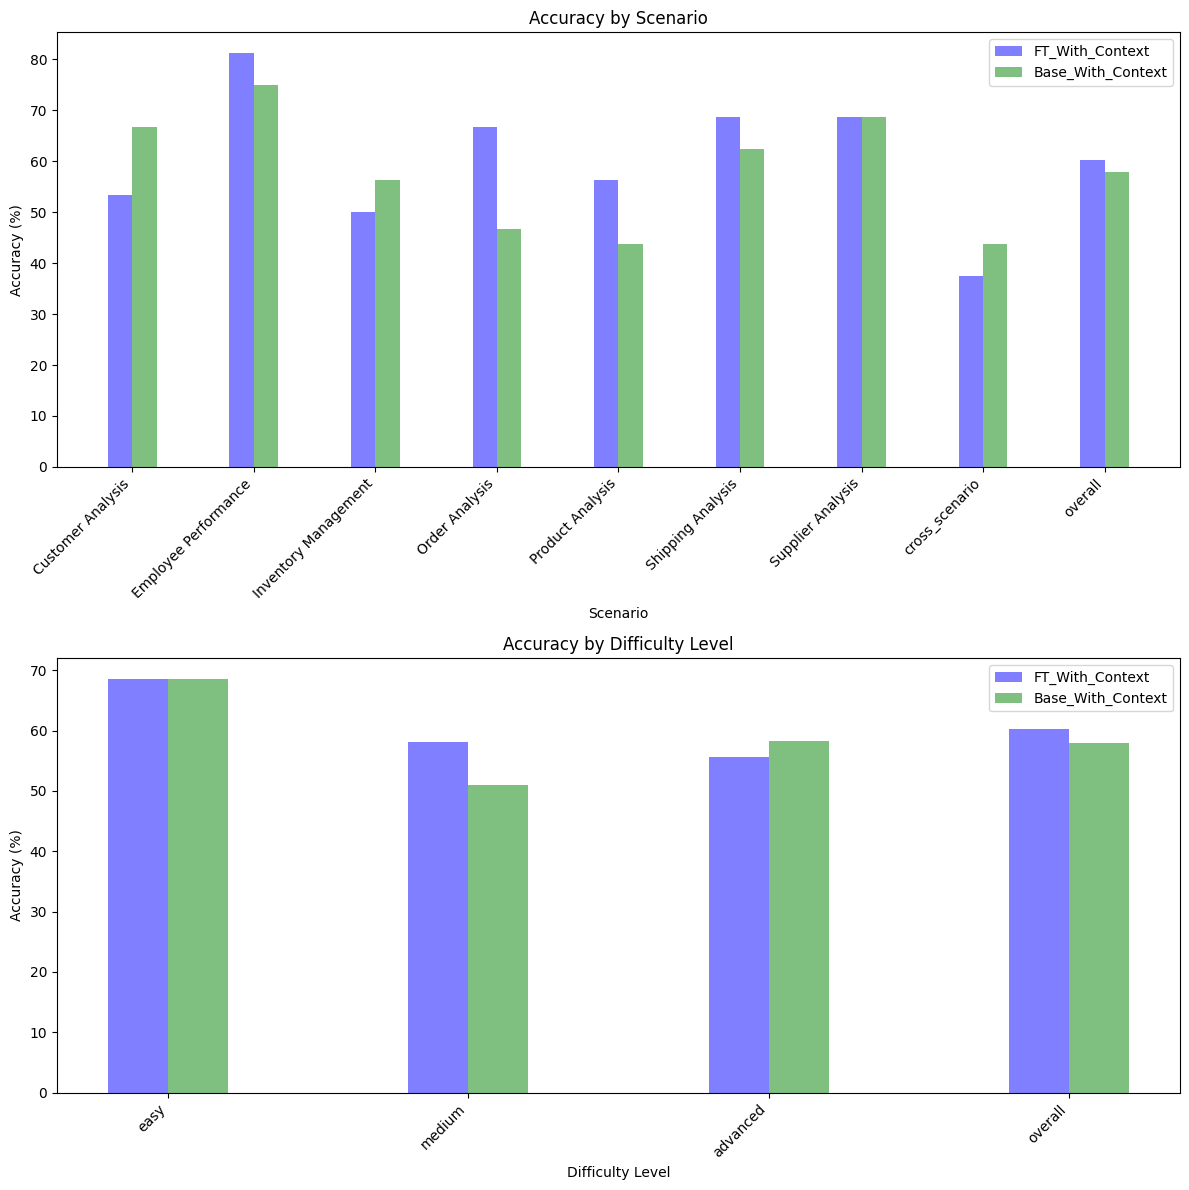

In [5]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from concurrent.futures import ThreadPoolExecutor  
import csv  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  

# Load environment variables  
env_path = Path('../../') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data_v5.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model with context
  
def generate_sql_query_with_context(question, schema):  
    formatted_question = f"## Database Schema and Business Metrics Definitions\n{schema}\n\n## Question: {question}"  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_CTX"),  
        messages=[  
            {"role": "system", "content": "You are a smart AI assistant with excellent SQL and data analysis skills. You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": formatted_question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question, schema):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database.\n ## Database Schema and Business Metrics Definitions\n{schema} \nWhat is the ANSI SQL query for the following question? Just output the SQL query without comment or explanation in this format ```sql YOUR SQL query here```"},  
            {"role": "user", "content": question},  
        ],  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_sql_query_with_explanation(question, generated_query, ground_truth_query):  
    user_message = f"""  
    Evaluate if the generated SQL query accurately answers the user's question and yields the same results as the ground truth query. The queries do not need to be identical.

    ## User Question: {question}
    ## Generated SQL Query: {generated_query}
    ## Ground Truth SQL Query: {ground_truth_query}

    ## Output Format:
    - Provide a one-word response: 'yes' or 'no'.
    - Include a brief explanation in JSON format: {{"result": "yes/no", "explanation": "explanation"}}.

    Your Output:
    """  
  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are a smart AI assistant, you have excellent data analysis and SQL skills. You apply SQL ANSI standard"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model with context  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    generated_query_with_context_ft = generate_sql_query_with_context(question, schema)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question, schema)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_with_context_ft, explanation_ft = evaluate_sql_query_with_explanation(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base, explanation_base = evaluate_sql_query_with_explanation(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        question,  
        ground_truth_query,  
        generated_query_with_context_base,  
        explanation_base,  
        generated_query_with_context_ft,  
        explanation_ft,  
        "Base" if evaluation_result_with_context_base == 'yes' and evaluation_result_with_context_ft == 'no' else "FT" if evaluation_result_with_context_ft == 'yes' and evaluation_result_with_context_base == 'no' else "both" if evaluation_result_with_context_ft == 'yes' and evaluation_result_with_context_base == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_sql.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "User Question",  
        "Ground Truth SQL Query",  
        "Generated SQL by Base Model",  
        "Explanation by Base Model",  
        "Generated SQL by FT Model",  
        "Explanation by FT Model",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_With_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 0.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 0.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  
